# Visualize Top Epilepsy Predictions from Project Rephetio

Uses [PK's manual curation](https://thinklab.com/d/203#14) of the top 100 [epilepsy predictions](http://het.io/repurpose/browse.html?id=DOID_1826).

In [1]:
library(magrittr)

In [2]:
window_df = suppressMessages(readr::read_tsv('data/windows.tsv')) %>%
  dplyr::mutate(disease_rank = dplyr::row_number(-disease_pctl))

head(window_df)

name,prediction,disease_pctl,phcodb,trials,category,min_pred,max_pred,freq_AIGD,freq_IGD,freq_UNKD,disease_rank
Topiramate,0.603,1.0000,DM,35,AIGD,0.460,0.603,1,0,0,1
Ethotoin,0.589,0.9993,NA,0,AIGD,0.434,0.603,1,0,0,2
Quazepam,0.570,0.9987,NA,0,AIGD,0.430,0.603,1,0,0,3
Alprazolam,0.565,0.9980,NA,1,AIGD,0.409,0.603,1,0,0,4
Primidone,0.494,0.9974,DM,0,AIGD,0.402,0.603,1,0,0,5
Lorazepam,0.489,0.9967,NA,11,AIGD,0.381,0.603,1,0,0,6


In [3]:
range(window_df$disease_pctl)

[1] 0.935 1.000

In [4]:
area_df = window_df %>%
  tidyr::gather(window_status, window_freq, dplyr::starts_with('freq_')) %>%
  tidyr::separate(window_status, c('temp', 'window_status'), '_') %>%
  dplyr::select(-temp)

area_df$window_status = factor(area_df$window_status, levels=c('AIGD', 'UNKD', 'IGD'))

area_df %<>% dplyr::arrange(window_status)
area_df %>% head(2)

name,prediction,disease_pctl,phcodb,trials,category,min_pred,max_pred,disease_rank,window_status,window_freq
Topiramate,0.603,1.0000,DM,35,AIGD,0.460,0.603,1,AIGD,1
Ethotoin,0.589,0.9993,NA,0,AIGD,0.434,0.603,2,AIGD,1


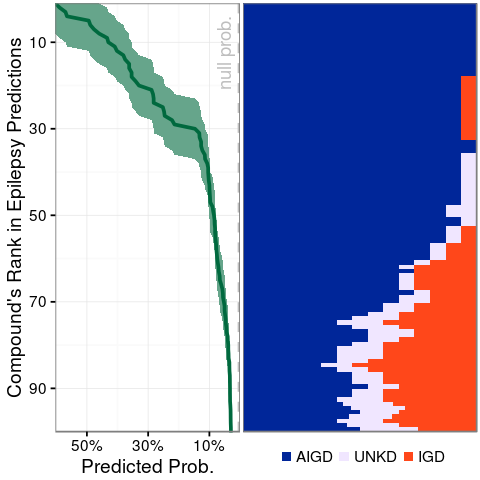

In [5]:
color_map = c(AIGD='#002699', UNKD='#f0e6ff', IGD='#ff471a')
null_prob = 0.00361

gg_pred = window_df %>%
  ggplot2::ggplot(ggplot2::aes(x = disease_rank)) +
  ggplot2::geom_hline(yintercept = null_prob, size=0.7, linetype='dashed', color='grey') +
  ggplot2::annotate('text', x=4, y=null_prob, color='grey', label='null prob.', angle=90, vjust=-0.54, hjust=1) +
  ggplot2::geom_ribbon(ggplot2::aes(ymin = min_pred, ymax = max_pred), fill = '#66A58B') +
  ggplot2::geom_line(ggplot2::aes(y = prediction), size=1.05, lineend='round', color='#00693E') +
  ggplot2::coord_flip() +
  hetior::theme_dhimmel() +
  #ggplot2::scale_x_reverse(breaks=window_df$disease_rank, labels=tolower(window_df$name)) +
  ggplot2::scale_x_reverse(breaks=seq(10, 90, 20), expand=c(0,0), name="Compound's Rank in Epilepsy Predictions") +
  ggplot2::scale_y_reverse(expand=c(0,0), breaks=seq(.1, .5, .2), labels=scales::percent, name='Predicted Prob.') +
  ggplot2::expand_limits(y = 0) +
  ggplot2::theme(plot.margin = grid::unit(c(2, 0, 2, 2), 'points'))


gg_status = dplyr::bind_rows(
  area_df %>% dplyr::mutate(disease_rank = disease_rank - 0.499),
  area_df %>% dplyr::mutate(disease_rank = disease_rank + 0.499)) %>%
  dplyr::arrange(disease_rank) %>%
  ggplot2::ggplot(ggplot2::aes(x = disease_rank, y = window_freq, fill=window_status)) +
  ggplot2::geom_area() +
  ggplot2::scale_fill_manual(values=color_map, name=NULL) +
  hetior::theme_dhimmel() +
  ggplot2::coord_flip() +
  ggplot2::scale_x_reverse(name=NULL, labels=NULL, expand=c(0,0)) +
  ggplot2::scale_y_continuous(expand=c(0,0), name=NULL, labels=NULL) +
  ggplot2::theme(legend.position = 'bottom', axis.ticks=ggplot2::element_blank()
                 #, legend.background = ggplot2::element_rect(fill='gray90')
  ) +
  ggplot2::guides(fill = ggplot2::guide_legend(keywidth=.5, keyheight=.5)) +
  ggplot2::theme(plot.margin = grid::unit(c(2, 2, 2, -1), 'points'))

gg_window = cowplot::plot_grid(gg_pred, gg_status)


w = 4; h = 4

options(repr.plot.width=w, repr.plot.height=h)
gg_window

In [6]:
# Save to file
ggplot2::ggsave('figure/epilepsy-windows.png', gg_window, width = w, height = h, dpi=300)
ggplot2::ggsave('figure/epilepsy-windows.pdf', gg_window, width = w, height = h)

## Single pane visualization

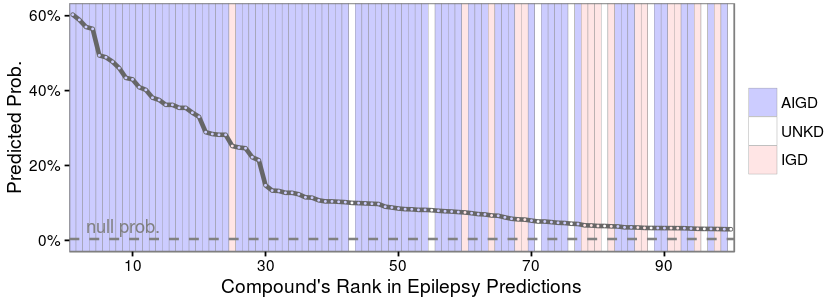

In [7]:
w = 7; h = 2.5

color_map = c(AIGD='#ccccff', UNKD='#ffffff', IGD='#ffe5e5')

options(repr.plot.width=w, repr.plot.height=h)
gg_epilepsy = window_df %>%
  ggplot2::ggplot(ggplot2::aes(x = disease_rank, y = prediction)) +
  ggplot2::geom_tile(ggplot2::aes(x = disease_rank, fill=category), width=1, height=Inf, color='#8c8c8c') +
  ggplot2::geom_hline(yintercept = null_prob, size=0.7, linetype='dashed', color='#808080') +
  ggplot2::annotate('text', x=3, y=null_prob, color='#808080', label='null prob.', vjust=-0.4, hjust=0) +
  ggplot2::geom_line(size=1.3, lineend='round', color='#666666') +
  ggplot2::geom_point(ggplot2::aes(color=category), size=0.15) +
  hetior::theme_dhimmel() +
  ggplot2::scale_fill_manual(values=color_map, name=NULL, breaks=names(color_map)) +
  ggplot2::scale_color_manual(values=color_map, name=NULL, guide=F) +
  ggplot2::scale_x_continuous(breaks=seq(10, 90, 20), expand=c(0,0), name="Compound's Rank in Epilepsy Predictions") +
  ggplot2::scale_y_continuous(breaks=seq(.0, .6, .2), labels=scales::percent, name='Predicted Prob.') +
  ggplot2::expand_limits(y = 0) +
  ggplot2::theme(plot.margin = grid::unit(c(2, 0, 2, 2), 'points'))

gg_epilepsy

In [8]:
ggplot2::ggsave('figure/epilepsy.png', gg_epilepsy, width = w, height = h, dpi=300)
ggplot2::ggsave('figure/epilepsy.pdf', gg_epilepsy, width = w, height = h)

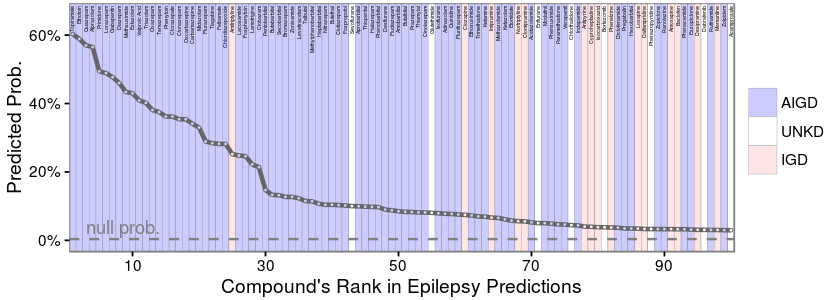

In [9]:
# Add compound names
gg_epilepsy_labeled = gg_epilepsy +
  ggplot2::geom_text(ggplot2::aes(label = name), y=0.686, angle=90, size=1.1, hjust=1, vjust=0.45) +
  ggplot2::expand_limits(y = .660)

gg_epilepsy_labeled

In [10]:
ggplot2::ggsave('figure/epilepsy-labeled.png', gg_epilepsy_labeled, width = w, height = h, dpi=300)
ggplot2::ggsave('figure/epilepsy-labeled.pdf', gg_epilepsy_labeled, width = w, height = h)

## Session Information for reproducibility

In [11]:
sessionInfo()

R version 3.3.1 (2016-06-21)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.1 LTS

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] magrittr_1.5

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.6        cowplot_0.6.2      munsell_0.4.3      uuid_0.1-2        
 [5] colorspace_1.2-6   R6_2.1.2           stringr_1.0.0      plyr_1.8.4        
 [9] dplyr_0.5.0        tools_3.3.1        grid_3.3.1         gtable_0.2.0      
[13] DBI_0.4-1          lazyeval_0.2.0     assertthat_0.1     digest_0.6.10     
[17] tibble_1.1         I